In [1]:
from forgebox.imports import *
from forgebox.ftorch.cuda import CudaHandler
from transformers import AutoModel,AutoTokenizer, get_cosine_schedule_with_warmup
from typing import Dict, List
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader, default_collate
from copy import deepcopy

from datetime import datetime

The model files

In [2]:
tag = "roberta-large"

In [3]:
pretrained = "weights/pre_rbtlg"

In [4]:
tokenizer = AutoTokenizer.from_pretrained('./rbt_lg_pre')
model = AutoModel.from_pretrained(pretrained)

Some weights of the model checkpoint at weights/pre_rbtlg were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at weights/pre_rbtlg and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [5]:
from forgebox.config import Config

In [6]:
CONFIG = Config(
    learning_rate=1e-6,
    top_lr_expansion=1e3,
    max_epochs = 15,
    frozen_years = 3,
    drop_out_ratio=.2,
    use_scheduler = True,
)

## A look at the data

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("train.csv").head(20)
display(train_df.head())

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [8]:
# batch = tokenizer(list(train_df.head()["excerpt"]), return_tensors="pt", padding=True)

# token_ids = batch["input_ids"]
# attention_mask = batch["attention_mask"]

# attention_mask

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


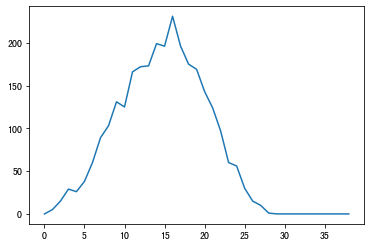

In [9]:
plt.plot(train_df.target.groupby(pd.cut(list(train_df.target),
                                        bins = list(i*.2-4 for i in  range(40)))).count())

In [10]:
class LitDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.indices = df.index
        
    def __len__(self,): return len(self.df)
    
    def __getitem__(self, idx):
        row_ = dict(self.df.loc[self.indices[idx]])
        row = dict((k,v) for k,v in row_.items() if k in ["excerpt","id","target"])
        return row
    
    def collate(self, batch):
        batch = default_collate(batch)
        batch["excerpt"] = tokenizer(batch["excerpt"], 
                                     truncation=True,
                                     return_tensors='pt', 
                                     return_token_type_ids=False, 
                                     padding=True,
                                     max_length=model.config.max_position_embeddings
                                    )
        if 'target' in batch:
            batch['target'] = batch['target'].float()
        return batch

In [11]:
train_ds = LitDataset(train_df)

In [12]:
BATCH_SIZE = 12
def create_dl(df, istrain = True):
    """
    Create dataloader from a dataframe
    """
    ds = LitDataset(df)
    dl = DataLoader(ds, shuffle=istrain,
                    batch_size=BATCH_SIZE if istrain else BATCH_SIZE*2,
                    collate_fn = ds.collate)
    return dl

In [13]:
a_dl = create_dl(train_df)
batch = next(iter(a_dl))
batch

{'id': ['c429433da',
  '610ee98eb',
  '3ef19afed',
  '39651417c',
  '27ae759b3',
  '79bd72801',
  '4a94fedd7',
  '4bff73b96',
  'c544d9384',
  '776e8cdec',
  '865e80e6a',
  '466727e29'],
 'excerpt': {'input_ids': tensor([[    0,  2264,   473,  ...,     1,     1,     1],
         [    0,   243,    21,  ...,     1,     1,     1],
         [    0,   100,    21,  ...,     1,     1,     1],
         ...,
         [    0,  4148,   494,  ...,     1,     1,     1],
         [    0, 14124,     8,  ...,     1,     1,     1],
         [    0,   170,   439,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])},
 'target': tensor([ 0.2272, -0.4081, -1.3642, -2.2739, -2.5898, -2.2242, -1.2863, -0.4197,
         -0.9749, -0.5679, -1.0959, -1.7276])}

In [14]:
def split_k(df, k: int=5):
    kmap = np.random.choice(range(k), size=len(df))
    return dict((ki, dict(train=(kmap!=ki), valid=(kmap==ki))) for ki in range(5))
        

In [15]:
split_5 = split_k(train_df, 5)
split_5

{0: {'train': array([ True,  True, False, ...,  True,  True, False]),
  'valid': array([False, False,  True, ..., False, False,  True])},
 1: {'train': array([ True, False,  True, ..., False, False,  True]),
  'valid': array([False,  True, False, ...,  True,  True, False])},
 2: {'train': array([ True,  True,  True, ...,  True,  True,  True]),
  'valid': array([False, False, False, ..., False, False, False])},
 3: {'train': array([False,  True,  True, ...,  True,  True,  True]),
  'valid': array([ True, False, False, ..., False, False, False])},
 4: {'train': array([ True,  True,  True, ...,  True,  True,  True]),
  'valid': array([False, False, False, ..., False, False, False])}}

## DataModule

In [16]:
class LitDataMod(pl.LightningDataModule):
    def __init__(self, train_df, test_df, split_map: Dict[str, np.ndarray]):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.split_map = split_map
        
    def train_dataloader(self):
        df = self.train_df[self.split_map["train"]]
        return create_dl(df, istrain=True)
    
    def val_dataloader(self):
        df = self.train_df[self.split_map["valid"]]
        return create_dl(df, istrain=False)
    
    def test_dataloader(self):
        df = self.test_df
        return create_dl(df, istrain=False)
    


## Module

In [17]:
model.pooler = nn.Linear(model.config.hidden_size, 1)

### Freeze/ unfreeze

In [18]:
# ====================== GRADUAL UNFREEZE ======================
def unfreeze(self):
    """unfreeze this module, and its sub modules"""
    for p in self.parameters():
        p.requires_grad = True
        
def freeze(self):
    """freeze this module, and its sub modules"""
    for p in self.parameters():
        p.requires_grad = False
        
def measure_freeze(m:nn.Module)->"a describtion about how many submodules are unfreezed":
    total = 0
    trainable = 0
    for param in m.parameters():
        total+=1
        if param.requires_grad: trainable+=1
    return f"☀️ {trainable} trainables/{total} total"
        
nn.Module.unfreeze = unfreeze
nn.Module.freeze = freeze

class GradualUnfreeze(pl.callbacks.Callback):
    """
    A Callback that will deploy ULMFit's gradual unfreeze trick
    """
    def on_epoch_start(self, trainer, pl_module):
        epoch = trainer.current_epoch
        
        if epoch==0:
            pl_module.freeze()
        
        # layers from top to bottom
        glist = pl_module.gradual_list()
        
        if epoch<len(glist):
            print(f"🔥 unfreezing [{type(glist[epoch])}] on [epoch {epoch}]")
            glist[epoch].unfreeze()
                
            # print out statistics for current unfreezing
            print(f"{measure_freeze(pl_module)}")
            
class FineTuneScheduler(pl.callbacks.Callback):
    """
    Train the top layer for 2 epoch
    then un freeze all
    """
    def on_epoch_start(self, trainer, pl_module):
        epoch = trainer.current_epoch
        
        if epoch==0:
            pl_module.freeze()
            for tl in pl_module.top_layers:
                tl.unfreeze()
        if epoch==CONFIG.frozen_years:
            pl_module.unfreeze()
            pl_module.base.embeddings.freeze()

# ====================== OPTIMIZER CONFIGURATION ======================
def modules_to_opt_conf(modules,**opt_kwargs)->"a list of PyTorch optimizer config":
    """
    put in a sequence of pytorch modules, 
    return optimizer param groups of configs
    """
    param_list = []
    param_list_nd = []
    no_decay = ["bias", "LayerNorm.weight"]
    for m in modules:
        for n,p in m.named_parameters():
            if any(nd in n for nd in no_decay):
                param_list_nd.append(p)
            else:
                param_list.append(p)
                
    opt_kwargs_nd = deepcopy(opt_kwargs)
    opt_kwargs_nd["weight_decay"]=0.
    return [dict(params=param_list,**opt_kwargs), # param_group with weight decay
            dict(params=param_list_nd,**opt_kwargs_nd), # param_group without weight decay
           ]

In [19]:
def init_config(config, **kwargs):
    for k, v in kwargs.items():
        setattr(model.config, k, v)
    return config

In [20]:
from tqdm.notebook import tqdm
# inf_dl = LitDataMod(train_df, test_df, split_5[0]).test_dataloader()

## Train schema

In [21]:
class BaseModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = CONFIG.learning_rate
        self.use_scheduler = CONFIG.learning_rate
        self.crit = nn.MSELoss()
#         self.crit = nn.KLDivLoss()

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        x = batch["excerpt"]
        y = batch["target"]

        y_ = self(x)
        loss = self.crit(y_[:, 0], y)
        self.log("loss", loss)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        x = batch["excerpt"]
        y = batch["target"]

        y_ = self(x)
        loss = self.crit(y_[:, 0], y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        x = batch["excerpt"]
        ids = batch["id"]

        y_ = self(x)

        target = y_.detach().cpu().numpy().reshape(-1)

        return pd.DataFrame({"id": ids, "target": target})

    @property
    def top_layers(self):
        return [self.reg, ]

    def gradual_list(self) -> List[nn.Module]:
        """
        Return a list of list of nn.Modules, 
        for the modules to be unfreezed by the start of each epoch
        """
        # top layer
        rt = self.top_layers

        # encoder layers
        rt += list(self.base.encoder.layer)[::-1]

        # embedding
        rt += [model.embeddings, ]
        return rt

    def configure_optimizers(self,):
        """
        Create the optimizer
        """
        gradual = self.gradual_list()

        no_decay = ["bias", "LayerNorm.weight"]
        h = self.config
        # top layer param group
        opt_configs = modules_to_opt_conf(self.top_layers,
                                          lr=self.learning_rate*CONFIG.top_lr_expansion,
                                          eps=h.adam_epsilon,
                                          weight_decay=h.weight_decay)

        delay = len(self.top_layers)
        # encoder layer one by one from top to bottom param group
        for i in range(len(gradual)-delay):
            opt_configs += modules_to_opt_conf([gradual[i+delay], ],
                                               lr=self.learning_rate * (h.layerwise_lr_decay**(i+1)),
                                               eps=h.adam_epsilon,
                                               weight_decay=h.weight_decay)

        optimizer = torch.optim.AdamW(opt_configs)
        self.opt = optimizer
        if self.use_scheduler:
            scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                        num_warmup_steps=0,
                                                        num_training_steps= 2e4)
            return dict(optimizer = optimizer, lr_scheduler = scheduler)
        return optimizer

### Headers & Poolers

In [22]:
class CLSReg(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Linear(base.config.hidden_size, 1)

    def forward(self, excerpt: torch.Tensor) -> torch.Tensor:
        x = excerpt["input_ids"]
        vec = self.base(x).last_hidden_state[:, 0, :]
        return self.reg(vec)


class CLSnn(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Sequential(
            nn.Linear(base.config.hidden_size,
                      base.config.hidden_size, bias=False),
            nn.BatchNorm1d(base.config.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(base.config.hidden_size, 1),
        )

    def forward(self, excerpt: torch.Tensor) -> torch.Tensor:
        x = excerpt["input_ids"]
        vec = self.base(x).last_hidden_state[:, 0, :]
        return self.reg(vec)
    
    
class MeanPooler(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Linear(base.config.hidden_size, 1)
        self.dropout = nn.Dropout(CONFIG.drop_out_ratio)
        
    def reduce_hidden_state(self, vec, attention_mask):
        vec = vec*(attention_mask[...,None])
        return vec.sum(dim=1)/(attention_mask.sum(-1)[...,None])

    def forward(self, excerpt: torch.Tensor) -> torch.Tensor:
        x = excerpt["input_ids"]
        attention_mask = excerpt["attention_mask"]
        vec = self.base(x).last_hidden_state
        vec = self.reduce_hidden_state(vec, attention_mask)
        return self.reg(self.dropout(vec))


# class MeanPooler(BaseModel):
#     def __init__(self, base):
#         super().__init__()
#         self.base = base
#         self.config = self.base.config
#         self.reg = nn.Linear(base.config.hidden_size, 1)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         vec = self.base(x).last_hidden_state.mean(dim=1)
#         return self.reg(vec)


class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector


class WithAttnHead(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.head = AttentionHead(
            self.config.hidden_size, self.config.hidden_size)
        self.dout = nn.Dropout(.1)
        self.reg = nn.Linear(base.config.hidden_size, 1)

    def forward(self, excerpt: torch.Tensor) -> torch.Tensor:
        x = excerpt["input_ids"]
        attention_mask = excerpt["attention_mask"]
        vec = self.base(x).last_hidden_state
        vec *= (attention_mask[...,None])
        return self.reg(self.dout(self.head(vec)))

    @property
    def top_layers(self):
        return [self.reg, self.head]

## Training

### Device and Save

In [23]:
dev = CudaHandler().idle().device.index

>>> 2 cuda devices found >>>
Device 0: 
	name:Tesla V100-PCIE-32GB
	used:4MB	free:32506MB
Device 1: 
	name:Tesla V100-PCIE-32GB
	used:8773MB	free:23737MB
cuda stats refreshed
Found the most idle GPU: cuda:0, 32506 MB Mem remained


In [24]:
ModelClass = MeanPooler

train_time = datetime.now().strftime("%d_%H%M%S")
WEIGHTS = Path(f"weights/{ModelClass.__name__}_cyclr_{train_time}/")
WEIGHTS.mkdir(parents=True, exist_ok=True)

WEIGHTS

PosixPath('weights/MeanPooler_cyclr_27_174728')

### Run folds

In [ ]:
for fold in tqdm(range(len(split_5)), leave=False):
    model = AutoModel.from_pretrained(pretrained)
    lit_model = ModelClass(model)
    lit_model.base.config = init_config(lit_model.base.config,
        layerwise_lr_decay = 1.,
        adam_epsilon = 1e-6,
        weight_decay = 0.01
    )
#     lit_model.freeze()

    saver = pl.callbacks.ModelCheckpoint(dirpath=WEIGHTS, monitor="val_loss",mode="min",
                                         save_top_k=1, save_weights_only=True,
                             filename='{epoch}-{val_loss:.2f}'+f"fd{fold}")
    
    early = pl.callbacks.EarlyStopping(
        "val_loss", mode="min", patience=5)
    
    trainer = pl.Trainer(
        max_epochs=CONFIG.max_epochs,
        callbacks=[saver, early, FineTuneScheduler()],
        logger=False,
        fast_dev_run=False,
        gpus=[dev,],
#         auto_lr_find = True,
    )
    trainer.tune(lit_model,datamodule=LitDataMod(
        train_df, test_df, split_5[fold]))
    print(f"[LEARNING RATE]{lit_model.learning_rate}")
    trainer.fit(lit_model,datamodule=LitDataMod(
        train_df, test_df, split_5[fold]))
    lit_model = lit_model.cpu()

    print(f"[SAVE]{WEIGHTS}")

Some weights of the model checkpoint at weights/pre_rbtlg were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at weights/pre_rbtlg and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

[LEARNING RATE]1e-06



  | Name    | Type         | Params
-----------------------------------------
0 | crit    | MSELoss      | 0     
1 | base    | RobertaModel | 355 M 
2 | reg     | Linear       | 1.0 K 
3 | dropout | Dropout      | 0     
-----------------------------------------
355 M     Trainable params
0         Non-trainable params
355 M     Total params
/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


### Deliver empety weights


In [ ]:
if len(WEIGHTS.ls()) ==0:
    print(f"[REMOVE EMPETY]{WEIGHTS}")
    WEIGHTS.rmdir()